https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4

# Install Library

In [1]:
pip install pythainlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 76.5 MB/s eta 0:00:00


In [2]:
pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234911 sha256=fb50a4299bd66318f74934f13971e502b3a72e2334bbaa5b2e32117792438271
  Stored in directory: /root/.cache/pip/wheels/02/3d/88/51a592b9ad17e7899126563698b4e3961983ebe85747228ba6
Successfully built emoji


In [3]:
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd
import numpy as np
import re
import emoji

from pythainlp.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

from gensim.test.utils import common_texts
from gensim.models import Word2Vec

from keras.layers import Embedding
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.metrics import Precision, Recall
from keras.callbacks import History

import tensorflow as tf

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt

from datetime import datetime
from keras import callbacks

import keras.backend as K

# Import file

In [5]:
# import csv file
df = pd.read_csv('data_all.csv', delimiter=',')

In [6]:
df.loc[:,'text'] = df.loc[:,'text'].map(word_tokenize)

In [7]:
df

,label,text
0,1.0,[1]
1,1.0,[สวัสดี]
2,1.0,"[อรุณสวัสดิ์, , ดู, ข่าว]"
3,1.0,"[D, , jai]"
4,1.0,"[สวัสดี, ชาวโลก]"
...,...,...
11954,1.0,"[จุดแข็ง, หัว, , จุดอ่อน, ที่อยู่]"
11955,1.0,[]
11956,1.0,"[เจอ, ไฟไหม้, , โทร, แจ้ง, , เบอร์]"
11957,0.0,"[แม่, ง, เก่ง]"


## create list of text

In [8]:
sent = [row for row in df['text']]

## Tokenize and pad sequence

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.text)

In [10]:
# create X
X = pad_sequences(tokenizer.texts_to_sequences(df.text), maxlen=20)
X

array([[   0,    0,    0, ...,    0,    0,  133],
       [   0,    0,    0, ...,    0,    0,   39],
       [   0,    0,    0, ...,    1,   25,   20],
       ...,
       [   0,    0,    0, ...,  692,    1,  891],
       [   0,    0,    0, ...,   19,   71,   41],
       [   0,    0,    0, ...,    0,    0, 3979]], dtype=int32)

In [11]:
# create y
y = df['label']
y.shape

(11959,)

# Load Word2Vec(TNCc5model)

In [12]:
# load pretrained model
model = Word2Vec.load("http://www.arts.chula.ac.th/ling/wp-content/uploads/TNCc5model.bin") 

In [13]:
# model.save("TNCc5model.model")

In [14]:
# model = Word2Vec.load("TNCc5model.model")

In [15]:
# create vocab_size, embedding_dim and embedding_matrix
vocab_size = len(model.wv)
embedding_dim = model.vector_size
embedding_matrix = np.zeros((vocab_size, embedding_dim))

In [ ]:
for i, word in enumerate(model.wv):
    embedding_matrix[i] = word

In [17]:
embedding_matrix[31077]

array([-0.08747477, -0.03003867,  0.0696032 ,  0.03697103, -0.04840473,
        0.04570374,  0.08035568,  0.09319719,  0.0328302 ,  0.0205396 ,
        0.05725439,  0.07493409, -0.05307385,  0.06657625,  0.02432919,
       -0.01523621, -0.03918364,  0.00505913,  0.09474613,  0.07713508,
        0.01310679,  0.01618158,  0.03159253, -0.05961249, -0.00540888,
        0.01102536,  0.03336877, -0.09733387, -0.0455462 ,  0.00984617,
        0.0461374 ,  0.04063138, -0.01614906,  0.02336541, -0.05779864,
       -0.01610914, -0.09162895, -0.06487005, -0.01570138,  0.01779037,
       -0.01921744, -0.01817694,  0.12782034,  0.0127709 , -0.00602525,
       -0.03969072,  0.01731815,  0.00555995,  0.04609034,  0.05480786,
        0.05582551, -0.02981856, -0.01753935, -0.03173018,  0.03811059,
        0.08742324, -0.03593688, -0.08428604,  0.00821297, -0.03246153,
       -0.04117111,  0.11976431, -0.02667627, -0.03977206, -0.01023334,
        0.09782189,  0.02933291, -0.05686831,  0.0734435 , -0.03

# Create model

In [18]:
embedding_layer = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=20, trainable=False)

In [19]:
model = Sequential()
model.add(embedding_layer)
#model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 100)           3107800   
                                                                 
 dropout (Dropout)           (None, 20, 100)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 256)              234496    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 3)                 771       
                                                                 
Total params: 3,343,067
Trainable params: 235,267
Non-trainable params: 3,107,800
________________________________________

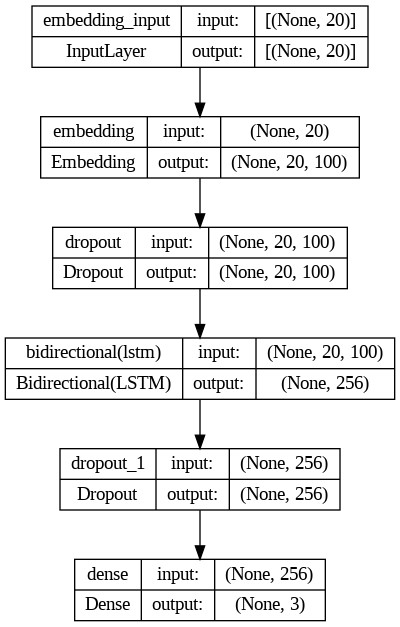

In [20]:
tf.keras.utils.plot_model(model, show_shapes=True)

# Splitting Data and prepare X and y

In [21]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# Apply SMOTE to the training data
smote = SMOTE()
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X_train_oversampled, y_train_oversampled, test_size=0.25, random_state=1)
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (13599, 20) (13599,)
Validation Set -> (4533, 20) (4533,)
Test Set -> (2392, 20) (2392,)


## Data distribution

<Axes: >

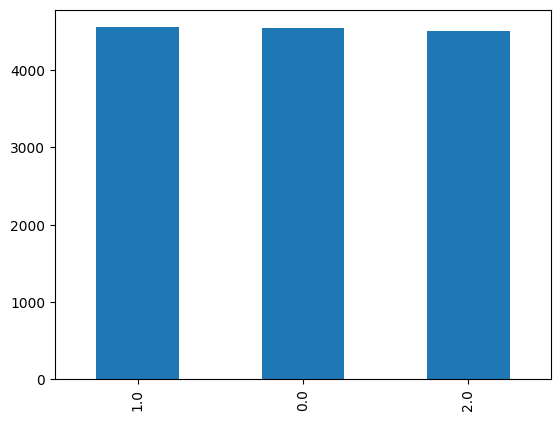

In [24]:
CountStatus = pd.value_counts(y_train.values)
CountStatus.plot.bar()

<Axes: >

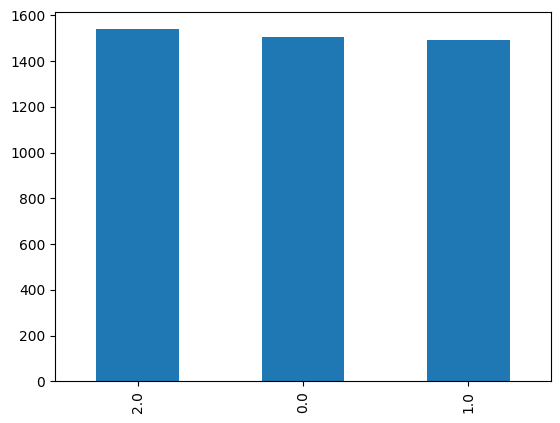

In [25]:
CountStatus = pd.value_counts(y_val.values)
CountStatus.plot.bar()

<Axes: >

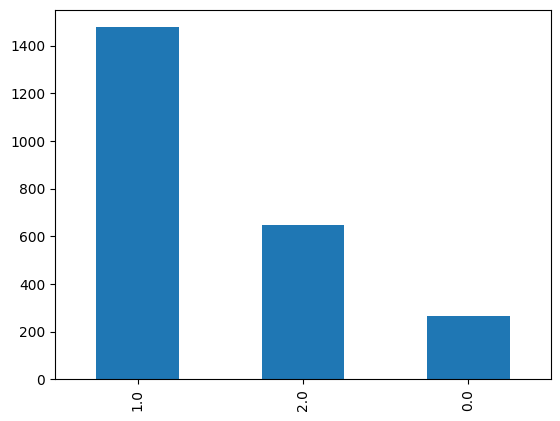

In [26]:
CountStatus = pd.value_counts(y_test.values)
CountStatus.plot.bar()

## create y to 3 output

In [27]:
y_train = pd.get_dummies(y_train)
y_val = pd.get_dummies(y_val)
y_test = pd.get_dummies(y_test)

In [28]:
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (13599, 20) (13599, 3)
Validation Set -> (4533, 20) (4533, 3)
Test Set -> (2392, 20) (2392, 3)


# Train Data

In [29]:
start_time = datetime.now()

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="weights.hdf5", monitor = 'val_accuracy', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, batch_size=8, callbacks=[checkpointer] )

model.load_weights('weights.hdf5')

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Epoch 1/15
1700/1700 [==============================] - ETA: 0s - loss: 1.0075 - accuracy: 0.4798 - precision: 0.6011 - recall: 0.2344
Epoch 1: val_accuracy improved from -inf to 0.51688, saving model to weights.hdf5
1700/1700 [==============================] - 95s 49ms/step - loss: 1.0075 - accuracy: 0.4798 - precision: 0.6011 - recall: 0.2344 - val_loss: 0.9562 - val_accuracy: 0.5169 - val_precision: 0.6459 - val_recall: 0.2705
Epoch 2/15
1700/1700 [==============================] - ETA: 0s - loss: 0.9234 - accuracy: 0.5470 - precision: 0.6573 - recall: 0.3390
Epoch 2: val_accuracy improved from 0.51688 to 0.54136, saving model to weights.hdf5
1700/1700 [==============================] - 73s 43ms/step - loss: 0.9234 - accuracy: 0.5470 - precision: 0.6573 - recall: 0.3390 - val_loss: 0.9291 - val_accuracy: 0.5414 - val_precision: 0.6342 - val_recall: 0.3591
Epoch 3/15
1700/1700 [==============================] - ETA: 0s - loss: 0.8722 - accuracy: 0.5852 - precision: 0.6854 - recall: 0

# Save model

In [ ]:
# Save the model architecture & the weights
model.save('w2v_bilstm.h5')
print('Best model saved')

Best model saved


# Evaluation

In [30]:
def f1_score(precision, recall):
    ''' Function to calculate f1 score '''
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [31]:
# Evaluate model on the test set
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))


Accuracy  : 0.6162
Precision : 0.6441
Recall    : 0.5644
F1 Score  : 0.6016


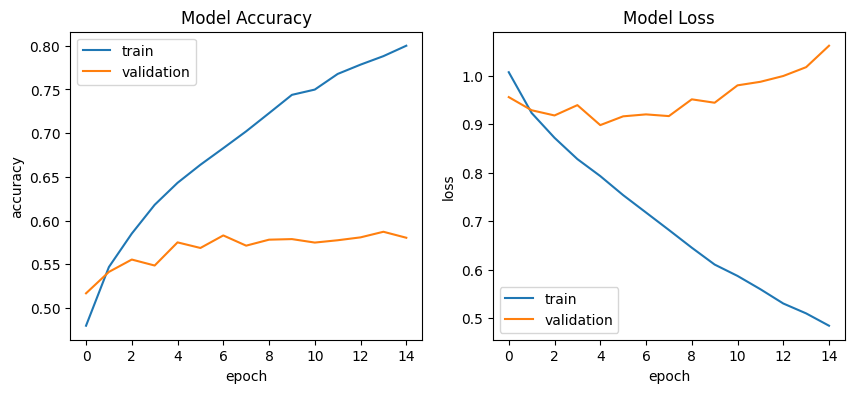

In [32]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''    
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history)

75/75 [==============================] - 2s 22ms/step


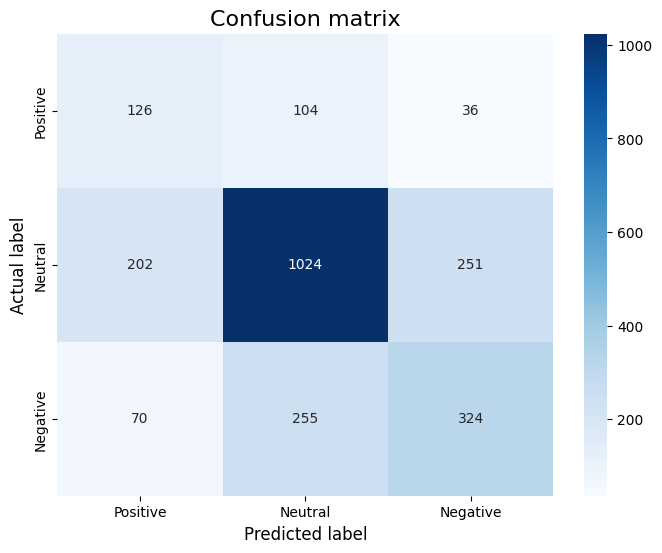

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Positive', 'Neutral', 'Negative']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Predicted label', fontsize=12)
    plt.ylabel('Actual label', fontsize=12)
    
plot_confusion_matrix(model, X_test, y_test)

In [ ]:
from keras.models import load_model

# Load model
model = load_model('w2v_bilstm.h5')


75/75 [==============================] - 7s 49ms/step


In [34]:
y_pred = model.predict(X_test)
y_pred_lst = np.argmax(np.array(y_pred),axis=1)

75/75 [==============================] - 2s 23ms/step


In [35]:
# create y
y = df['label']
y.shape
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_pred_lst = list(y_pred_lst)
y_test = list(y_test.astype(int))

In [36]:
# Print the precision and recall, among other metrics
from sklearn import metrics
# Print the confusion matrix
print(confusion_matrix(y_test, y_pred_lst))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_test, y_pred_lst, digits=3))

[[ 126  104   36]
 [ 202 1024  251]
 [  70  255  324]]
              precision    recall  f1-score   support

           0      0.317     0.474     0.380       266
           1      0.740     0.693     0.716      1477
           2      0.530     0.499     0.514       649

    accuracy                          0.616      2392
   macro avg      0.529     0.555     0.537      2392
weighted avg      0.636     0.616     0.624      2392



# Inference

In [ ]:
from keras.models import load_model

# Load model
model = load_model('w2v_bilstm.h5')

def predict_class(text):
    '''Function to predict sentiment class of the passed text'''
    
    sentiment_classes = ['Positive', 'Neutral', 'Negative']
    max_len=20
    
    # Transforms text to a sequence of integers using a tokenizer object
    t = [text]
    df2 = pd.DataFrame(list(t), columns = ['text'])
    df2.loc[:,'text'] = df2.loc[:,'text'].map(word_tokenize)
    # Pad sequences to the same length
    X = pad_sequences(tokenizer.texts_to_sequences(df2.text), maxlen=20)
    # Do the prediction using the loaded model
    yt = model.predict(X).argmax(axis=1)
    # Print the predicted sentiment
    print('The predicted sentiment is', sentiment_classes[yt[0]])

In [ ]:
predict_class('ดีครับ')

1/1 [==============================] - 3s 3s/step
The predicted sentiment is Positive


In [ ]:
predict_class('ลุงตู่')

1/1 [==============================] - 0s 32ms/step
The predicted sentiment is Positive


In [ ]:
predict_class('คคคคค')

1/1 [==============================] - 0s 27ms/step
The predicted sentiment is Negative


In [ ]:
predict_class('สวัสดีวันจันทร์')

1/1 [==============================] - 0s 30ms/step
The predicted sentiment is Neutral
